In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import dataset

import random
from sklearn import metrics
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [3]:
# Read/write directory parameters
#*************************************
datadir = 'training_data'
savemodeldir = 'new_model'
loadmodelpath = 'model/2018-10-30_03-12-21_model_epoch30.pth'

# Pytorch parameters
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
savemodel = True
savemodel_interval = 1  #if 0 (and savemodel=True) will only save model at the end of entire training
loadmodel = False

# Training parameters
#*************************************
batch_size = 5
num_epochs = 30
lr = 1e-4
log_interval = 1
random.seed(14) #for dataset splitting set to None of leave blank if do not need to preserve random order

# Preprocessing parameters
#*************************************
bins = 48
hrange = 24

In [4]:
def load_files(filelist,code='0001'):
    files = [file for file in filelist if code in file]
    return files

def plot3d(P,L):
    
    plt.rcParams["figure.figsize"] = (20,12)
    fig = plt.figure()    
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(P[0], P[1], P[2], c='r', marker='o')
    ax.scatter(L[0], L[1], L[2], c='b', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

['training_data\\0001_lig_cg.pdb'] ['training_data\\0011_pro_cg.pdb']


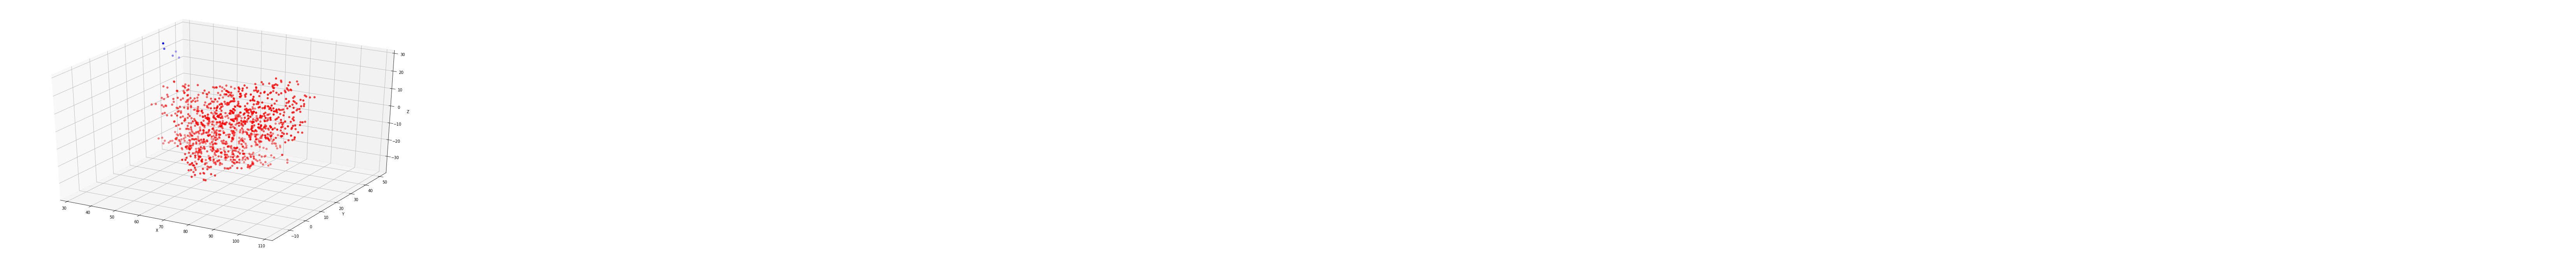

In [5]:
from mpl_toolkits.mplot3d import Axes3D

L_fileList, L_fnameList = dataset.listDirectory(datadir,'.pdb','lig')
P_fileList, P_fnameList = dataset.listDirectory(datadir,'.pdb','pro')
L_file = load_files(L_fileList,'0001')
P_file = load_files(P_fileList,'0011')
print(L_file,P_file)
P = dataset.read_pdb(P_file[0])
L = dataset.read_pdb(L_file[0])

plot3d(P,L)

In [6]:
# Initialize dataset & (validation) dataloader - train loader is defined in the training loop 
#*************************************
adataset = dataset.ProLigDataset(datadir,pos_ratio=300, neg_ratio=300)

validationdataset = dataset.miniDataset(adataset.test_set, format='int',
                                        transform=transform.Compose([dataset.create_voxel2(bins=bins,hrange=hrange),
                                                                     dataset.array2tensor(torch.FloatTensor)]))
                                        #target_transform=None) #dataset.array2tensor(torch.FloatTensor))

test_loader = torch.utils.data.DataLoader(dataset=validationdataset,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=False)

In [7]:
print(len(adataset.positive))
print(len(adataset.negative))

print(len(adataset.test_set))
print(len(adataset.negative_train))
print(len(adataset.positive_train))

print(adataset.test_set[:3]) #test whether random seed is working
print(adataset.negative_train[:3])
print(adataset.positive_train[:3])

3000
8997000
600
8996700
2700
[('training_data\\1644_pro_cg.pdb', 'training_data\\1059_lig_cg.pdb'), ('training_data\\1985_pro_cg.pdb', 'training_data\\2166_lig_cg.pdb'), ('training_data\\2287_pro_cg.pdb', 'training_data\\1141_lig_cg.pdb')]
[('training_data\\1112_pro_cg.pdb', 'training_data\\2011_lig_cg.pdb'), ('training_data\\2909_pro_cg.pdb', 'training_data\\2359_lig_cg.pdb'), ('training_data\\1564_pro_cg.pdb', 'training_data\\1974_lig_cg.pdb')]
[('training_data\\1794_pro_cg.pdb', 'training_data\\1794_lig_cg.pdb'), ('training_data\\1218_pro_cg.pdb', 'training_data\\1218_lig_cg.pdb'), ('training_data\\0610_pro_cg.pdb', 'training_data\\0610_lig_cg.pdb')]


In [8]:
print("size of dataset is",len(validationdataset))
print("no. of steps per epoch is",len(validationdataset)//batch_size)



for i in range(len(validationdataset)):
    sample,target = validationdataset[i]
    #plt.plot(sample['audio'])
    print(sample.shape)
    print(target)
    if i == 1:
        break

size of dataset is 600
no. of steps per epoch is 120
torch.Size([3, 48, 48, 48])
0
torch.Size([3, 48, 48, 48])
0


In [9]:
# Specify the model
#*************************************
class CNN2(nn.Module):
    # input size - the number of "classes"
    def __init__(self):
        super(CNN2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool3d(kernel_size=2, stride=2),)
        self.layer2 = nn.Sequential(
            nn.Linear(23328, 10),
            nn.ReLU())
        self.fc2 = nn.Linear(10, 1)
          #output size(2) if using cross-entropy, 1 if BCE/MSE
        #self.softmax = nn.Softmax()  #softmax already built in if using CrossEntropyLoss()
        
    def forward(self, x):
        #print(x.shape)
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)

        #print(out.shape)
        out = self.fc2(out)
        #out = self.softmax(out)
        #print(out.type())
        return out
    
    
class CNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=5, stride=1, padding=0),
            #nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 100),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #print("in",x.shape)
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc1(out)
        #print(out.shape)
        out = self.fc2(out)
        out = self.sigmoid(out)
        #print(out.type())
        return out

In [10]:
# Define the training cycle (100% teacher forcing for now)
#*************************************
def train(model,epoch):
    model.train() #put in training mode
    
    training_set = dataset.create_minidataset(adataset.negative_train, adataset.positive_train, 
                                              len(adataset.positive_train), epoch)

    minidataset = dataset.miniDataset(training_set,
                                      transform=transform.Compose([dataset.rotation3D(), #randomly rotate to augment 
                                                                   dataset.create_voxel2(bins=bins,hrange=hrange),
                                                                   dataset.array2tensor(torch.FloatTensor)]),
                                      target_transform=dataset.array2tensor(torch.FloatTensor))


    train_loader = torch.utils.data.DataLoader(dataset=minidataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=False)
    
    
    for step, (inp,target) in enumerate(train_loader):
        target = target.float()
        inp, target = inp.to(device), target.to(device)
        
        # Forward + Backward + Optimize
        outputs = model(inp)
        #print(outputs,target)
        loss = criterion(outputs, target)
        #print(loss.item())
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.6f}'.format( 
        datetime.now(), epoch+1, num_epochs, step+1, len(minidataset)//batch_size, loss.item()))
    
    list_of_losses.append(loss.item())
    
    if (epoch+1) % log_interval == 0:
        evaluate_mse(model)
                   
    if savemodel_interval != 0 and savemodel:
        if (epoch+1) % savemodel_interval == 0:
            torch.save(model.state_dict(),
                       '{}/{:%Y-%m-%d_%H-%M-%S}_model_epoch{}_step{}.pth'.format(savemodeldir,datetime.now(),epoch+1,step+1))
            print('model saved at epoch{} step{}'.format(epoch+1,step+1))


def evaluate(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inp, target in test_loader:
            inp, target = inp.to(device), target.to(device)
            outputs = model(inp)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()

        print('Accuracy of the model on the validation set: {} %'.format(100 * correct / total))
        
        
def evaluate_mse(model):
    model.eval()
    with torch.no_grad():
        out = []
        targets = []
        for step, (inp, target) in enumerate(test_loader):
            inp = inp.to(device)
            outputs = model(inp)
            outputs_numpy = outputs.detach().cpu().numpy()
            targets_numpy = target.numpy()
            for i in range(outputs_numpy.shape[0]):
                out.append(outputs_numpy.item(i))
                targets.append(targets_numpy.item(i))
        print(out)
        print(targets)
        auc = auc_curve(out,targets)
        list_of_auc.append(auc)
            
def auc_curve(output,target):
    """Plot a ROC curve"""
    fpr, tpr, _ = metrics.roc_curve(target,  output)
    auc = metrics.roc_auc_score(target, output)
    plt.figure() 
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    return(auc)
     

In [11]:
# Initialize the network, optimizer and objective func
#*************************************
cnn = CNN().to(device)
if loadmodel: # load checkpoint if needed
    print("Loading existing checkpoint...")
    cnn.load_state_dict(torch.load(loadmodelpath))
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(299,dtype=torch.float,device=device))  #
criterion = nn.MSELoss() #nn.BCEWithLogitsLoss()  ##nn.MSELoss()

2018-11-06 23:58:31 Starting training...
2018-11-06 23:59:13 Epoch [1/30], Step [1080/1080] Loss: 0.223177
[0.9359559416770935, 0.8968626856803894, 0.9454287886619568, 0.9482399821281433, 0.7882790565490723, 0.9120975136756897, 0.9509419798851013, 0.0025100589264184237, 0.9476670026779175, 0.0005830044974572957, 0.0005424964474514127, 0.9597523808479309, 0.8740605115890503, 0.9348931312561035, 0.9553036093711853, 0.9204238057136536, 0.0016672409838065505, 0.0005752021097578108, 0.8802196979522705, 0.0005995530518703163, 0.6812060475349426, 0.947998046875, 0.0005417265347205102, 0.3599526882171631, 0.8861773610115051, 0.8396971225738525, 0.0005714467260986567, 0.0005594658432528377, 0.0005314950249157846, 0.9077593684196472, 0.0005448340089060366, 0.9479960203170776, 0.8749956488609314, 0.6893765330314636, 0.9186678528785706, 0.0005243426421657205, 0.9202532172203064, 0.0005875136121176183, 0.8789346814155579, 0.033591702580451965, 0.0005783888627775013, 0.0006276493659242988, 0.8958273

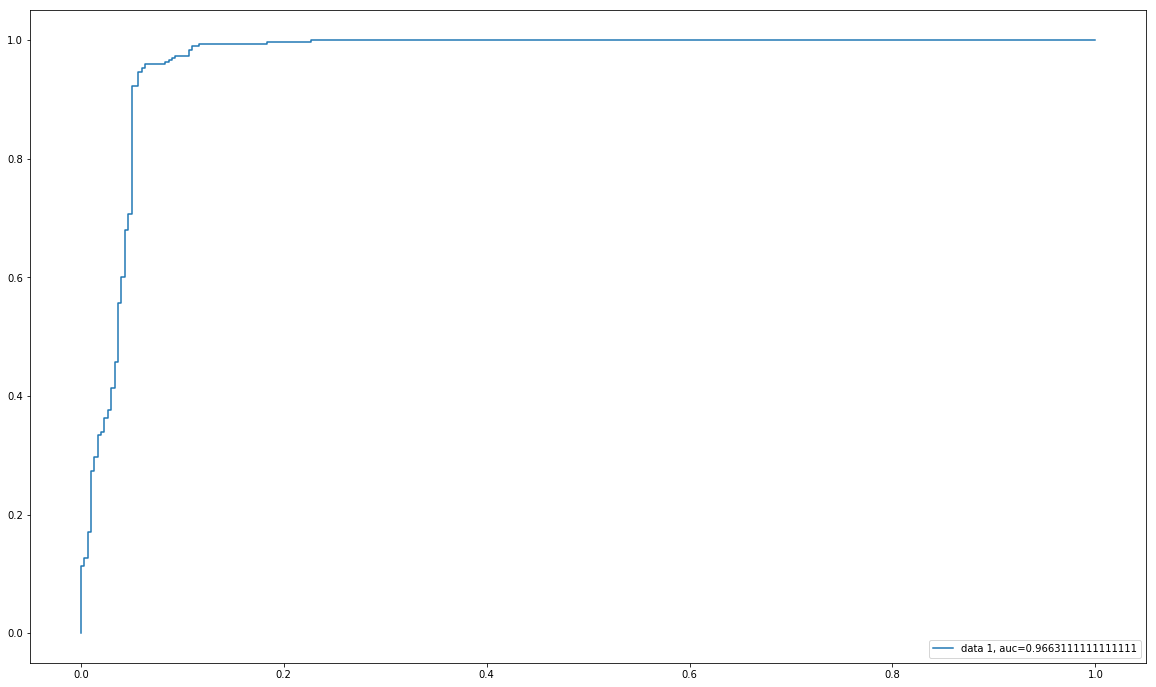

model saved at epoch1 step1080
2018-11-06 23:59:58 Epoch [2/30], Step [1080/1080] Loss: 0.249537
[0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.4933273196220398, 0.

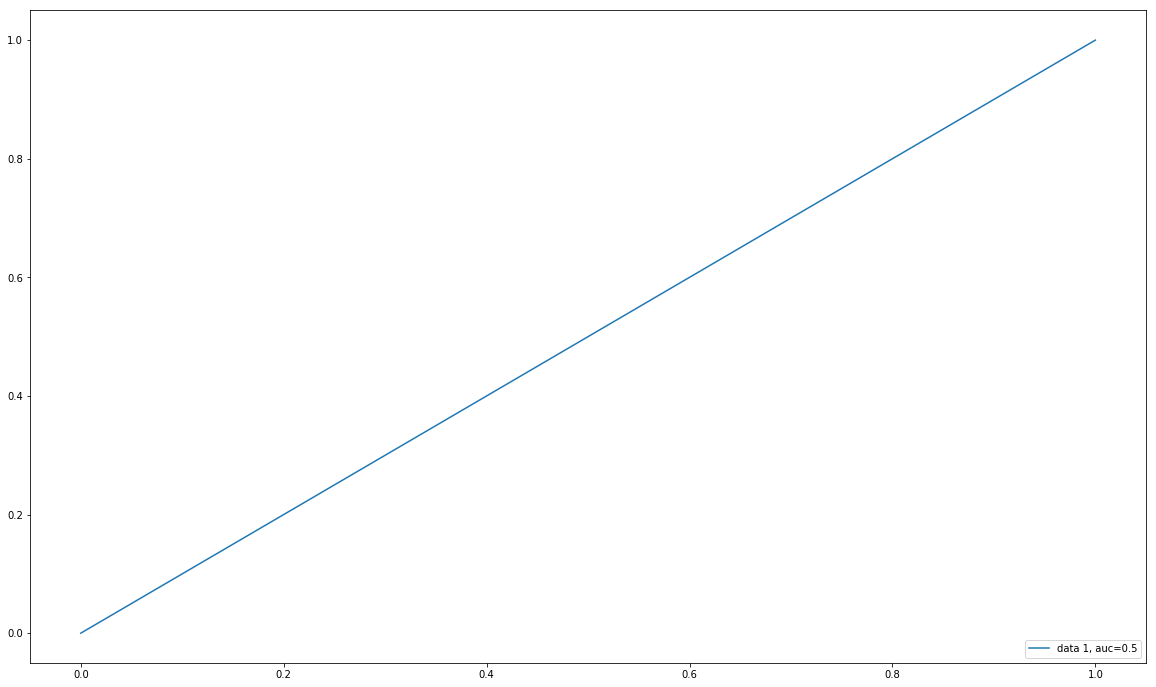

model saved at epoch2 step1080
2018-11-07 00:00:43 Epoch [3/30], Step [1080/1080] Loss: 0.247802
[0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653, 0.49663403630256653,

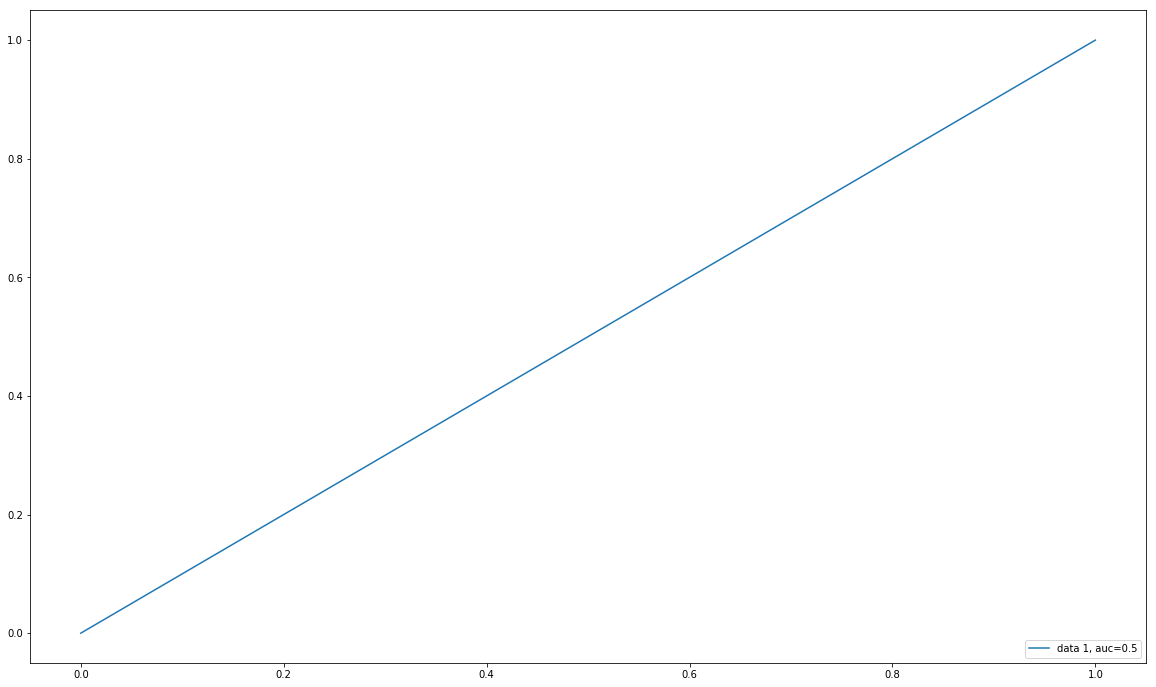

model saved at epoch3 step1080


KeyboardInterrupt: 

In [12]:
# Train!
#*************************************
list_of_losses = []
list_of_auc = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(cnn,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if savemodel_interval == 0 and savemodel:
    torch.save(cnn.state_dict(), 
       '{}/{:%Y-%m-%d_%H-%M-%S}_model_epoch{}.pth'.format(savemodeldir,datetime.now(),num_epochs))
    print('model saved at epoch{}'.format(num_epochs))

In [ ]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses[:-1])
plt.figure()
plt.plot(list_of_auc[:-1])